## Basic R-STDP Example

As an input for this basic R-STDP example we will give a `11x3` grid

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spike_dtype = np.dtype([('x', np.uint8), ('y', np.uint8), ('ts', np.float32)])
c1_spike_dtype = np.dtype([('grid', np.uint8), ('y', np.uint8), ('x', np.uint8), ('ts', np.float32)])

In [3]:
class Grid:
    """
        Each grid represents a pixel array with spikes occurring at
        a certain location at the given timestamp.
    """
    def __init__(self, xsize, ysize, grid):
        self.xsize = xsize
        self.ysize = ysize
        self.grid = grid
        
    @classmethod
    def get_grid(cls, i):
        """
            Allows easy initialization of a grid
        """
        if i == 0 :
            grid = np.array([[0,0,0,0,0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0,0,0,0,0]],
                           dtype=np.float32)
        elif i == 1 :
            grid = np.array([[1,0,0,0,5,6,7,0,0,0,9],
                             [2,3,0,0,0,8,0,0,0,10,11],
                             [4,0,0,0,0,0,0,0,0,0,12]],
                           dtype=np.float32)
            
        elif i == 2 :
            grid = np.array([[1,0,0,0,9,10,11,0,0,0,5],
                             [2,3,0,0,0,12,0,0,0,6,7],
                             [4,0,0,0,0,0,0,0,0,0,8]],
                           dtype=np.float32)
        else:
            raise ValueError('Not a supported grid type')
            
        return cls(11, 3, grid)
    
    def show(self):
        """
            Prints a visual representation of the grid including 
            spike's timestamps
        """
        grayscale = (self.grid > 0).astype(int)
        for (j, i), value in np.ndenumerate(self.grid):
            if value > 0 : plt.text(i, j, int(value))
        plt.imshow(grayscale, vmin=-1, vmax =1, cmap='gray')
        plt.xticks(range(self.grid.shape[1]), rotation=0)
        plt.show()
    
    @property
    def spikes(self):
        """
            Retrieves the grid spikes in a recarray format with
            spikes sorted by timestamp
        """
        grid_spikes = []
        for (j, i), value in np.ndenumerate(self.grid):
             if value > 0 : grid_spikes.append((i, j, value))
        np_spikes = np.array(grid_spikes, dtype=spike_dtype)
        np_spikes.sort(order='ts')
        return np_spikes
    
    @property
    def shape(self):
        return self.grid.shape
    
    def __str__(self):
        return f"{self.spikes}"
    
    def __repr__(self):
        return self.__str__()
    

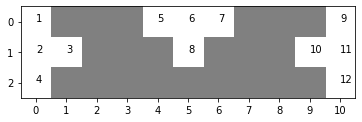

In [4]:
a = Grid.get_grid(1)
a.show()

In [5]:
a.spikes

array([( 0, 0,  1.), ( 0, 1,  2.), ( 1, 1,  3.), ( 0, 2,  4.),
       ( 4, 0,  5.), ( 5, 0,  6.), ( 6, 0,  7.), ( 5, 1,  8.),
       (10, 0,  9.), ( 9, 1, 10.), (10, 1, 11.), (10, 2, 12.)],
      dtype=[('x', 'u1'), ('y', 'u1'), ('ts', '<f4')])

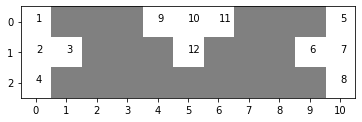

In [6]:
b = Grid.get_grid(2)
b.show()

# Neuronal Grids

The neuronal grid has $n$ integrate-and-fire (IF) neurons with threshold $\mathcal{T}$. Each neuron receives its inputs from a $\omega \times \omega$ window -- also called the neuron's receptive field (RF) -- through weighted plastic synapses. In order to provide the ability of detecting a particular feature over the entire spatial positions, all the neurons belonging to the same grid share the same weights.

At the arrival of a spike, we compute its relative position to a neuron $(x_r, y_r)$ and we increase the neuron's synaptic potential with the weight of the relative position if the spike is in its receptive field. In other words, the synaptic potential of neuron $i$ at time $t$ is: 

$$ v_i(t) = v_i(t-1) + \sum_{(x_r, y_r) \in {RF}}{w_{(x_r, y_r)} \cdot \delta(t-t_{spike}(j)}) $$

Each neuronal grid detects a feature, the idea is to have multiple grids and associate each grid to a class.

In [7]:
from numba import njit
import itertools 
import logging
#logging.basicConfig(filename='grid_mac.log',
                    #format='%(asctime)s | %(levelname)s | %(message)s',
                    #level=logging.INFO)

In [8]:
class NeuronalGrids:
    def __init__(self, input_grid_shape, neuron_rf=3, n_grids=4):
        
        self.input_grid_shape = input_grid_shape
        self.grid_shape = ((input_grid_shape[0] - neuron_rf + 1),
                           (input_grid_shape[1] - neuron_rf + 1))
        
        self.n_grids = n_grids
        self.neuron_rf = neuron_rf
        
        self.synaptic_weights = self.initialise_weights(n_grids, neuron_rf)
        self.neuron_potential = np.zeros((n_grids, *self.grid_shape), dtype=np.float32)
        
        self.sensitive_neurons_to_pos = self.get_sensitive_neurons()
        self.neuron_threshold = 3.2
        
        self.reset_metrics()
        self.Ar_plus = 0.075
        self.Ar_neg = -0.05
        self.Ap_plus = 0.04
        self.Ap_neg = -0.1
        
        self.dropouts = []
        
        # to keep weights between [small_qty, 1-small_qty]
        self.small_qty = 0.005
    
    def initialise_weights(self, n_grids, window_size, mu=0.8, sigma=0.05):
        """
            Initialises the grid weights with values sampled from a normal
            distribution mathcal{N}(mu, sigma2)
        """
        # extract as many random samples as needed
        grid = np.random.normal(mu, sigma, (n_grids, self.neuron_rf, self.neuron_rf))

        # return them as a matrix
        result = np.reshape(grid, (n_grids, self.neuron_rf, self.neuron_rf))
        #result = np.full((n_grids, self.neuron_rf, self.neuron_rf), 0.8)
        
        return result
    
    def reset_metrics(self):
        self.n_silence = 0
        self.n_hit = 0
        self.n_miss = 0
        self.n_samples = 0
                
    def get_temporal_winner(self, spikes, dropout=0.2, neuron_dropout=0.1):
        
        hasFired = False
        is_active = np.random.random((self.n_grids))
        is_active_neuron = np.random.random((self.grid_shape))
        
        for spike in spikes:
            for grid in range(self.n_grids):
                
                if is_active[grid] > dropout:
                    if not hasFired:

                        affected_neurons = self.sensitive_neurons(spike)

                        for neuron in affected_neurons:
                            
                            if is_active_neuron[neuron] > neuron_dropout:
                                
                                neuron_row, neuron_col = neuron
                            
                                relative_y, relative_x = self.relative_position(spike, neuron, self.neuron_rf)

                                logging.info(f'Processing spike {spike}, Neuron {(neuron_row, neuron_col)}, Grid {grid}' + \
                                         f'Relative Pos {(relative_y, relative_x)}')
                            
                                self.neuron_potential[grid, neuron_row, neuron_col] += self.synaptic_weights[grid, relative_y, relative_x]

                                if self.neuron_potential[grid, neuron_row, neuron_col] > self.neuron_threshold:
                                    out_spike = np.array([(grid, neuron_row, neuron_col, spike['ts'])], dtype=c1_spike_dtype)
                                    hasFired = True
                                    break
                                    
                            # else ignore neuron

                    else: # has fired
                        return out_spike[0]
                    
                # else skip grid
        else:
            return None
    
    def predict(self, spikes):
        
        self.neuron_potential = np.zeros((self.n_grids, *self.grid_shape), dtype=np.float32)
        winner_spike = self.get_temporal_winner(spikes, dropout=0, neuron_dropout=0)
        
        pred_class = None
        
        # if there is a winner: 
        if winner_spike is not None:
            # get the class prediction of the winner
            pred_class = winner_spike['grid'] % 2
        
        return pred_class
        
    def process(self, spikes, label, train=True):
        
        self.neuron_potential = np.zeros((self.n_grids, *self.grid_shape), dtype=np.float32)
        
        dropout=0.4*(1-self.n_hit/(self.n_samples+1))
        neuron_dropout=0.2*(1-self.n_hit/(self.n_samples+1))
        
        self.dropouts.append((dropout, neuron_dropout))
        
        winner_spike = self.get_temporal_winner(spikes, dropout, neuron_dropout)
        logging.info(winner_spike)
        
        # there can be no winners (no spikes), by default
        reward = False
        pred_class = None
        
        # if there is a winner: 
        if winner_spike is not None:
            
            # get the class prediction of the winner
            pred_class = winner_spike['grid'] % 2
            
            # get the corresponding reward:
            is_correct = (pred_class == label)
            reward = is_correct
            
            logging.info(f'Reward {reward}, label {label}')
            # compute metrics for performance and adjustment factor
            self.n_hit += int(is_correct)
            self.n_miss += int(is_correct)
            
            # if in training mode
            if train:
                # now we should trigger the learning process (only the winner grid updates its weights)
                self.synaptic_plasticity(winner_spike, reward, spikes)
        
        # else there was no winner (silence)
        else:
            # increase all weights equally to the grids associated to the class
            self.synaptic_weights[label] += 0.00005
            # consider that for metrics
            self.n_silence +=1
            
            # If none of the C2 neurons fire, no reward/punishment signal is generated, 
            # and thus, no weight change is applied.
            
                
        # whatever the result, we processed one image
        self.n_samples += 1
        
        return pred_class
    
    def synaptic_plasticity(self, winner_spike, reward, c1_spikes): 
        
        
        # self.synaptic_weights[winner_spike['grid']] contains the weights between C1 and S2, 
        # for a grid with one weight linking each orientation and (x,y) pixel
        
        grid_ix = winner_spike['grid']
        
        #if grid_ix==0: print(f"Winner spike {winner_spike}, correct {reward}")
        # get whether there was a C1 spike relevant to neuron (in its receptive field)
        # which spiked before the S2 spike
        spiked_before_post = self.get_whether_pre_spiked_before_post(winner_spike, c1_spikes)
        
        # compute RSTDP update
        computed_delta_weights = compute_RSTDP(self.synaptic_weights[grid_ix], spiked_before_post, reward, self.Ar_plus, self.Ar_neg, self.Ap_plus, self.Ap_neg)
        
        logging.info(f'Weights {self.synaptic_weights[grid_ix]}, Updates {computed_delta_weights}')
        
        # perform additive update rule with adaptive learning rate
        if reward:
            adjustment_factor = (self.n_miss+1)/(self.n_samples+1)
        else:
            adjustment_factor = (self.n_hit+1)/(self.n_samples+1)
        
        # apply the updates
        apply_update(self.synaptic_weights[grid_ix], computed_delta_weights, adjustment_factor, self.small_qty)
        
    def relative_position(self, spike, neuron, neuron_rf):
        row, col = neuron

        relative_row = spike['y'] - row
        relative_col = spike['x'] - col

        return relative_row, relative_col
    
    
    def get_sensitive_neurons(self):
        
        sensitive_neurons_to_pos = {}
        for y, x in itertools.product(range(self.input_grid_shape[0]), range(self.input_grid_shape[1])) :
            sensitive_neurons_to_pos[(y,x)] = []
        
        #print(sensitive_neurons_to_pos)
        for row, col in itertools.product(range(self.grid_shape[0]), range(self.grid_shape[1])):
            
            neuron_center_row = row + self.neuron_rf//2
            neuron_center_col = col + self.neuron_rf//2
            
            # relevant area for the neuron
            row_lb = neuron_center_row-self.neuron_rf//2
            row_ub = neuron_center_row+self.neuron_rf//2
            col_lb = neuron_center_col-self.neuron_rf//2
            col_ub = neuron_center_col+self.neuron_rf//2
            
            for y, x in itertools.product(range(row_lb, row_ub+1), range(col_lb, col_ub+1)):
                sensitive_neurons_to_pos[(y,x)].append((row, col))
                
        return sensitive_neurons_to_pos
                
    def sensitive_neurons(self, spike):
        return self.sensitive_neurons_to_pos[(spike['y'], spike['x'])]
    
    def get_whether_pre_spiked_before_post(self, s2_spike, c1_spikes):
        
        # we first need to understand which are the relevant rows and columns for an S2 neuron
        # if a receptive field is 5x5 we have a relevant region in [0:4, 0:4] with center in 2,2
        # this neuron centered in 2,2 is the S2 neuron (0,0), therefore:
        
        pre_spiked_before_post = np.full((self.neuron_rf, self.neuron_rf), False)
        
        neuron = (s2_spike['y'], s2_spike['x'])
        
        for spike in c1_spikes:
            
            #print(f"Winner spike {s2_spike}, current spike {spike}")
            
            if neuron in self.sensitive_neurons(spike):
                relative_y, relative_x = self.relative_position(spike, neuron, self.neuron_rf)
            
                # and it spiked before
                if(spike['ts'] <= s2_spike['ts']):
                    
                    #print(f"Yeah it spiked before and relevant")
                    # we signal true:
                    pre_spiked_before_post[relative_y, relative_x] = True
                    
               # else if silent or spiked later we keep it false
            
            # if not in receptive field we also keep it false
            
        return pre_spiked_before_post


### R-STDP

The weight updates are modulated by a reward/punishment signal which is received according to the correctness/incorrectness of the network's decision. The network's decision is given by the class associated to the grid which contains the first neuron to fire.

If reward:
$$\Delta w_{ij} = 
\begin{cases}
a_r^+ \times w_{ij} \times (1-w_{ij}) & \text{if } t^{f}_{j} \leq t^{f}_{input} \\
a_r^- \times w_{ij} \times (1-w_{ij}) &  \text{if } t^{f}_{j} > t^{f}_{input} \text{ or $j$ is silent }\\ 
\end{cases}$$

If punishment:
$$
\Delta w_{ij} = 
\begin{cases}
a_p^+ \times w_{ij} \times (1-w_{ij}) &  \text{if } t^{f}_{j} > t^{f}_{input} \text{ or $j$ is silent }\\ 
a_p^- \times w_{ij} \times (1-w_{ij}) & \text{if } t^{f}_{j} \leq t^{f}_{input} \\
\end{cases}$$

  
**If none of the neurons in the grids fire, no reward/punishment signal is generated and thus no weight change is applied.**

In [9]:
def compute_RSTDP(synaptic_weights, pre_spiked_before_post, reward, Ar_plus, Ar_neg, Ap_plus, Ap_neg):
    """
        Expects:
            -  synaptic weights from a given grid
            - a matrix indicating for each orientation row and column whether there was a spike
            in that position firing before the winner spike
            - reward or punishment
            - parameters for RSTDP
    """
    
    # get C1-S2 synapses parameters
    n_rows, n_cols = synaptic_weights.shape
    
    # initialize a container for the delta weights
    delta_weights = np.zeros((n_rows, n_cols))
    
    # for each orientation, row and column (i.e. for each synaptic weight)
    for (row, col), w_ij in np.ndenumerate(synaptic_weights):
        
        logging.info(f'Reward{reward}')
        if reward: # apply normal STDP
            
            if pre_spiked_before_post[row,col]:
                # correct decision, helpful neuron, boost weights so it reacts faster next time
                delta_weights[row,col] = Ar_plus * synaptic_weights[row,col] * (1-synaptic_weights[row,col])
                
            else: # spiked after or silent
                # correct decision, but not helpful spike, decrease weights ...
                delta_weights[row,col] = Ar_neg * synaptic_weights[row,col] * (1-synaptic_weights[row,col])

        else: # punishment signal reverses the polarity of STDP

            if pre_spiked_before_post[row,col]:
                # bad decision, decrease weights so we don't make the mistake next time
                delta_weights[row,col] = Ap_neg * synaptic_weights[row,col] * (1-synaptic_weights[row,col])
                
            else: # spiked after or silent
                # bad decision, but increase weights just to be sensitive to something else
                delta_weights[row,col] = Ap_plus * synaptic_weights[row,col] * (1-synaptic_weights[row,col])
    
    return delta_weights


In [10]:
def apply_update(synaptic_weights, computed_delta_weights, adjustment_factor, small_qty):
    """ 
        Expects:
            - synaptic weights from a given grid
            - a delta weights computed with rstdp
            - an adjustment factor acting as a learning rate
            - a small quantity to keep weights between [small_qty, 1-small_qty]
    """

    synaptic_weights += adjustment_factor * computed_delta_weights

    # keep weights between 0 and 1
    for (row, col), _ in np.ndenumerate(synaptic_weights):

        if synaptic_weights[row, col] >= (1 - small_qty) : 
            synaptic_weights[row, col] = 1 - small_qty
        elif synaptic_weights[row, col] <= 0 : 
            synaptic_weights[row, col] = 0 + small_qty

In [11]:
ng = NeuronalGrids(a.shape, n_grids=2)

In [12]:
for (j,i), elem in np.ndenumerate(a.grid):
    if elem > 0 : 
        print(f'Spike x={i}, y={j}')
        affected_neurons = ng.sensitive_neurons_to_pos[(j,i)]
        for neuron in affected_neurons:
            relative_y, relative_x = ng.relative_position(np.array([(i, j, 0)], dtype=spike_dtype), neuron, 3)
            print(f'\t Affected {neuron}, Relative position: x={relative_x} y={relative_y}')

Spike x=0, y=0
	 Affected (0, 0), Relative position: x=[0] y=[0]
Spike x=4, y=0
	 Affected (0, 2), Relative position: x=[2] y=[0]
	 Affected (0, 3), Relative position: x=[1] y=[0]
	 Affected (0, 4), Relative position: x=[0] y=[0]
Spike x=5, y=0
	 Affected (0, 3), Relative position: x=[2] y=[0]
	 Affected (0, 4), Relative position: x=[1] y=[0]
	 Affected (0, 5), Relative position: x=[0] y=[0]
Spike x=6, y=0
	 Affected (0, 4), Relative position: x=[2] y=[0]
	 Affected (0, 5), Relative position: x=[1] y=[0]
	 Affected (0, 6), Relative position: x=[0] y=[0]
Spike x=10, y=0
	 Affected (0, 8), Relative position: x=[2] y=[0]
Spike x=0, y=1
	 Affected (0, 0), Relative position: x=[0] y=[1]
Spike x=1, y=1
	 Affected (0, 0), Relative position: x=[1] y=[1]
	 Affected (0, 1), Relative position: x=[0] y=[1]
Spike x=5, y=1
	 Affected (0, 3), Relative position: x=[2] y=[1]
	 Affected (0, 4), Relative position: x=[1] y=[1]
	 Affected (0, 5), Relative position: x=[0] y=[1]
Spike x=9, y=1
	 Affected (0,

In [13]:
correct = 0
n_iters = 2000
# Train
for i in range(n_iters):
    rand_number = random.random()
    if rand_number > 0.5 :
        #print("\nProcessing 0")
        pred = ng.process(a.spikes, 0)
        correct += int(pred == 0) 
        logging.info('-'*20 + f'Predicted {pred}, real {0}')
    else:
        #print("\nProcessing 1")
        pred = ng.process(b.spikes, 1)
        correct += int(pred == 1) 
        logging.info('-'*20 + f'Predicted {pred}, real {1}')
    
print(f'Accuracy: {correct/(n_iters)}')

Accuracy: 0.365


In [14]:
# Test
correct = 0
n_iters = 2000
for i in range(n_iters):
    rand_number = random.random()
    if rand_number > 0.5 :
        #print("\nProcessing 0")
        pred = ng.predict(a.spikes)
        correct += int(pred == 0) 
        logging.info('-'*20 + f'Predicted {pred}, real {0}')
    else:
        #print("\nProcessing 1")
        pred = ng.predict(b.spikes)
        correct += int(pred == 1) 
        logging.info('-'*20 + f'Predicted {pred}, real {1}')
    
print(f'Accuracy: {correct/(n_iters)}')

Accuracy: 1.0


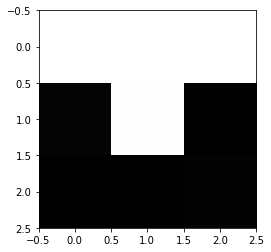

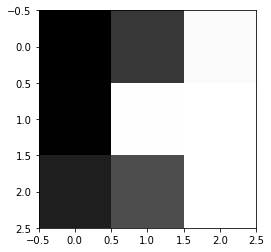

In [15]:
for i in range(len(ng.synaptic_weights)):
    plt.imshow(ng.synaptic_weights[i], cmap='gray')
    plt.show()

In [16]:
ng.synaptic_weights[1]

array([[0.29974401, 0.4496994 , 0.98274299],
       [0.30387455, 0.98899019, 0.99357771],
       [0.38130218, 0.50966247, 0.99377217]])

In [17]:
ng.dropouts

[(0.4, 0.2),
 (0.4, 0.2),
 (0.4, 0.2),
 (0.4, 0.2),
 (0.4, 0.2),
 (0.4, 0.2),
 (0.3428571428571429, 0.17142857142857146),
 (0.30000000000000004, 0.15000000000000002),
 (0.3111111111111111, 0.15555555555555556),
 (0.32000000000000006, 0.16000000000000003),
 (0.32727272727272727, 0.16363636363636364),
 (0.33333333333333337, 0.16666666666666669),
 (0.3384615384615385, 0.16923076923076924),
 (0.3142857142857143, 0.15714285714285714),
 (0.32000000000000006, 0.16000000000000003),
 (0.325, 0.1625),
 (0.3058823529411765, 0.15294117647058825),
 (0.2888888888888889, 0.14444444444444446),
 (0.2947368421052632, 0.1473684210526316),
 (0.30000000000000004, 0.15000000000000002),
 (0.3047619047619048, 0.1523809523809524),
 (0.3090909090909091, 0.15454545454545454),
 (0.3130434782608696, 0.1565217391304348),
 (0.30000000000000004, 0.15000000000000002),
 (0.30400000000000005, 0.15200000000000002),
 (0.3076923076923077, 0.15384615384615385),
 (0.3111111111111111, 0.15555555555555556),
 (0.300000000000000